####**Project Description:** 
This python program finds the current weather data of the most populated cities in the United States using city names from Wikipedia and data from the OpenWeatherMap API. It visualizes how a city's latitude affects different weather properties.

In [2]:
#import required modules
import requests, json
from collections import defaultdict
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

In [3]:
# Scrape a table from a webpage and store the results in a data frame.
# Call it DF1. 
# This table must have at least 30 records.

# store URL as a variable
url = "https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population"

# Make a request to a web page
html_content = requests.get(url)

# Initialize the BeautifulSoup object
soup = BeautifulSoup(html_content.content, "html.parser")

# this method prints the contents of the page in a clear, easy to read format
# print(soup.prettify())

In [4]:
# Gathering data for DF1

# find_all method looks through a tag’s descendants and retrieves all descendants that match filters
all_tables=soup.find_all("table")

right_table=soup.find('table', class_='wikitable sortable')

# Creating empty list for each column
L1 = []
city_name = []
L4 = []
L7 = []
L11 = []
Latitude = []
Longitude = []

# the findAll method -> findAll(name, attrs, recursive, string, **keywords)
right_table.findAll('tr')

# 35 records
for row in right_table.findAll('tr')[0:36]: #create limit to avoid exceeding config variable

  cells=row.findAll('td')

  #get text
  if len(cells)==11:
    # city number
    L1.append(cells[0].find(text=True).rstrip("\n")) 
    # city name
    city_name.append(cells[1].find('a').get_text().rstrip("\n"))
    # population estimate for 2019
    L4.append(cells[3].find(text=True).rstrip("\n"))
    # Land Area in sq mi - Removing "sq mi" after value
    L7.append(cells[6].find(text=True).rstrip("\n")[:len(cells[6])-6])

# This contains latitude and longitude data 
Location = list(soup.find_all('span', {'class': 'geo'}))
# Appending latitude and longitude data
count = 0
for i in Location:
  locate = i.get_text()
  Latitude.append(locate.split(";")[0]) 
  Longitude.append(locate.split(";")[1])
  count += 1
  if count == 35:
    break

# creating a dataframe as DF1, containing city names, population, land area in sq mi, latitude, and longitude data
DF1=pd.DataFrame()
DF1['Rank'] = L1
DF1['City_name'] = city_name
DF1['2019_Population'] = L4
DF1['2016_Land_Area_sq_mi'] = L7
DF1['Latitude'] = Latitude
DF1['Longitude'] = Longitude

# remove comma from value
DF1['2019_Population'] = DF1['2019_Population'].str.replace(',', '')
DF1['2016_Land_Area_sq_mi'] = DF1['2016_Land_Area_sq_mi'].str.replace(',', '')

# Convert to float
DF1['Latitude'] = DF1['Latitude'].astype(float)
DF1['Longitude'] = DF1['Longitude'].astype(float)

# Rounding latitude and longitude data
decimals = 2    
DF1['Latitude'] = DF1['Latitude'].apply(lambda x: round(x, decimals))
DF1['Longitude'] = DF1['Longitude'].apply(lambda x: round(x, decimals))

In [5]:
# Print first data frame containing city names, population, land area in sq mi, latitude, and longitude data
DF1.head()

,Rank,City_name,2019_Population,2016_Land_Area_sq_mi,Latitude,Longitude
0,1,New York City,8253213,301.5,40.66,-73.93
1,2,Los Angeles,3970219,468.7,34.01,-118.41
2,3,Chicago,2677643,227.3,41.83,-87.68
3,4,Houston,2316120,637.5,29.78,-95.39
4,5,Phoenix,1708127,517.6,33.57,-112.09


In [6]:
#enter api key for OpenWeatherMap
api_key = ""

#base url = "http://api.openweathermap.org/data/2.5/weather?"

#returns a dictionary-like object with list value
initial_dic=defaultdict(list)

In [7]:
#get the weather data

#use the values from one column as parameters to make requests to API 
for i in city_name:
  #complete_url variable to store address 
  complete_url = 'http://api.openweathermap.org/data/2.5/weather?appid=X&q={}&units=imperial'.format(i)

  #get method of requests module, return response object
  response = requests.get(complete_url)
  # print(response)

  #json method of response object
  #convert json format data into python format data
  x = response.json()

  #Store the (at least) 5 pieces of data returned from the API in another df (DF2). 
  if x["cod"] != "404": 

    #main is the object
    y = x["main"] 

    #store the current temperature (degrees Fahrenheit)
    current_temperature = y["temp"]

    #store the min temp (degrees Fahrenheit)
    temp_min = y['temp_min']

    #store the max temp (degrees Fahrenheit)
    temp_max = y['temp_max']

    #store the current pressure 
    current_pressure=y["pressure"]

    #store the current humidity
    current_humidity=y["humidity"]

    #visibility is the object - value in meters
    visibility = x["visibility"] 

    #wind is the object - mph
    z = x["wind"] 

    #store the wind in mph
    speed = z["speed"]

    # Appending data to initial_dic
    initial_dic['City_name'].append(i)

    # append data from OpenWeatherMap API 
    initial_dic['Current_temperature'].append(current_temperature)
    initial_dic['Min_temperature'].append(temp_min)
    initial_dic['Max_temperature'].append(temp_max)
    initial_dic['Pressure_hPa_unit'].append(current_pressure)
    initial_dic['Humidity_percentage'].append(current_humidity)
    initial_dic['Visibility_meters'].append(visibility)
    initial_dic['Wind_speed_mph'].append(speed)
 
  else:
    print("These cities were not found: ")
    print(i)

In [18]:
# Converting to DataFrame
DF2 = pd.DataFrame(initial_dic)

# temperature is in degrees Fahrenheit 

# Print DF2, which contains the weather data for each city
DF2.head()

,City_name,Current_temperature,Min_temperature,Max_temperature,Pressure_hPa_unit,Humidity_percentage,Visibility_meters,Wind_speed_mph
0,New York City,84.85,78.94,89.85,1013,53,10000,1.01
1,Los Angeles,63.66,57.96,76.06,1016,75,10000,3.00
2,Chicago,83.91,81.77,85.41,1012,47,10000,1.99
3,Houston,81.97,77.65,85.39,1012,73,10000,1.01
4,Phoenix,91.81,88.14,95.70,1010,14,10000,3.00


In [19]:
# Merge the two data frames horizontally (side by side) into a third data frame.
# DF3 is the result data frame
DF3 = pd.merge(DF1, DF2, how='left', on=['City_name'])

# temperature is in degrees Fahrenheit 

# Print DF3, which is the result of merging DF1 and DF2
DF3.head()

,Rank,City_name,2019_Population,2016_Land_Area_sq_mi,Latitude,Longitude,Current_temperature,Min_temperature,Max_temperature,Pressure_hPa_unit,Humidity_percentage,Visibility_meters,Wind_speed_mph
0,1,New York City,8253213,301.5,40.66,-73.93,84.85,78.94,89.85,1013,53,10000,1.01
1,2,Los Angeles,3970219,468.7,34.01,-118.41,63.66,57.96,76.06,1016,75,10000,3.00
2,3,Chicago,2677643,227.3,41.83,-87.68,83.91,81.77,85.41,1012,47,10000,1.99
3,4,Houston,2316120,637.5,29.78,-95.39,81.97,77.65,85.39,1012,73,10000,1.01
4,5,Phoenix,1708127,517.6,33.57,-112.09,91.81,88.14,95.70,1010,14,10000,3.00


In [10]:
# Print the statistics for the data frame
DF3.describe()

,Latitude,Longitude,Current_temperature,Min_temperature,Max_temperature,Pressure_hPa_unit,Humidity_percentage,Visibility_meters,Wind_speed_mph
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.0,35.000000
mean,36.787143,-97.792857,78.307429,74.010571,82.736571,1012.914286,55.171429,10000.0,3.650286
std,4.563497,16.387779,10.211622,11.106659,9.211509,3.958397,21.170854,0.0,2.706043
min,29.470000,-123.030000,55.720000,50.360000,58.480000,1002.000000,11.000000,10000.0,0.000000
25%,33.105000,-111.900000,75.390000,70.735000,78.845000,1011.000000,47.500000,10000.0,1.010000
50%,36.220000,-97.340000,81.880000,77.650000,85.210000,1013.000000,55.000000,10000.0,3.000000
75%,39.875000,-84.370000,84.625000,81.165000,88.195000,1016.000000,73.000000,10000.0,5.990000
max,47.620000,-71.020000,91.810000,88.480000,95.810000,1018.000000,85.000000,10000.0,9.980000


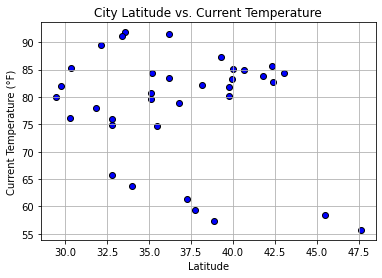

In [11]:
# Fun facts: 
# Latitude has a big effect on climate because latitude controls how much solar energy a location receives.
# There is a relationship between latitude and temperature around the world, as temperatures are typically warmer approaching the Equator and cooler approaching the Poles.

# Create Scatter Plot 
plt.scatter(DF3["Latitude"], DF3["Current_temperature"], facecolors="blue", marker="o", edgecolor="black")

# Graph Properties
plt.title("City Latitude vs. Current Temperature")
plt.ylabel("Current Temperature (°F)")
plt.xlabel("Latitude")
plt.grid(True)

# Show Plot
plt.show()

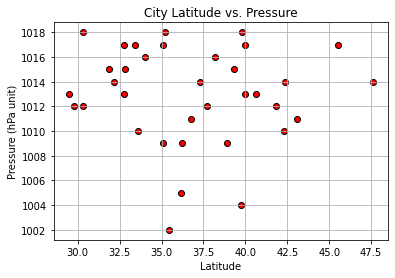

In [12]:
# Create Scatter Plot 
plt.scatter(DF3["Latitude"], DF3["Pressure_hPa_unit"], facecolors="red", marker="o", edgecolor="black")

# Graph Properties
plt.title("City Latitude vs. Pressure")
plt.ylabel("Pressure (hPa unit)")
plt.xlabel("Latitude")
plt.grid(True)

# Show Plot
plt.show()

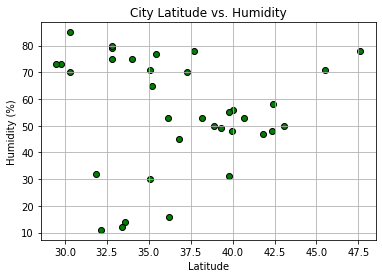

In [13]:
# Create Scatter Plot 
plt.scatter(DF3["Latitude"], DF3["Humidity_percentage"], facecolors="green", marker="o", edgecolor="black")

# Graph Properties
plt.title("City Latitude vs. Humidity")
plt.ylabel("Humidity (%)")
plt.xlabel("Latitude")
plt.grid(True)

# Show Plot
plt.show()

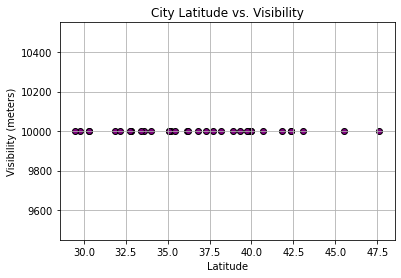

In [14]:
# Create Scatter Plot 
plt.scatter(DF3["Latitude"], DF3["Visibility_meters"], facecolors="purple", marker="o", edgecolor="black")

# Graph Properties
plt.title("City Latitude vs. Visibility")
plt.ylabel("Visibility (meters)")
plt.xlabel("Latitude")
plt.grid(True)

# Show Plot
plt.show()

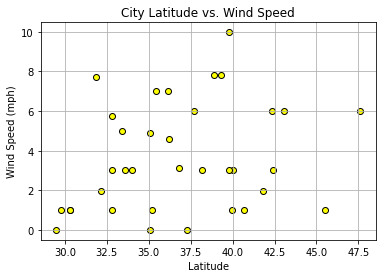

In [15]:
# Create Scatter Plot 
plt.scatter(DF3["Latitude"], DF3["Wind_speed_mph"], facecolors="yellow", marker="o", edgecolor="black")

# Graph Properties
plt.title("City Latitude vs. Wind Speed")
plt.ylabel("Wind Speed (mph)")
plt.xlabel("Latitude")
plt.grid(True)

# Show Plot
plt.show()

In [16]:
# Export the final data frame (DF3) to a csv file
DF3.to_csv('US Cities and their Weather Data.csv')

In [17]:
# Download the csv file to computer for convenience
from google.colab import files
files.download('US Cities and their Weather Data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>